In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch, make_D_use
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir, take_names

In [6]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['delaygo',]

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag' #train diag network
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [7]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig1','fig1_one_task_interp',w_init)
if not os.path.exists(figpath):
    os.makedirs(figpath)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt


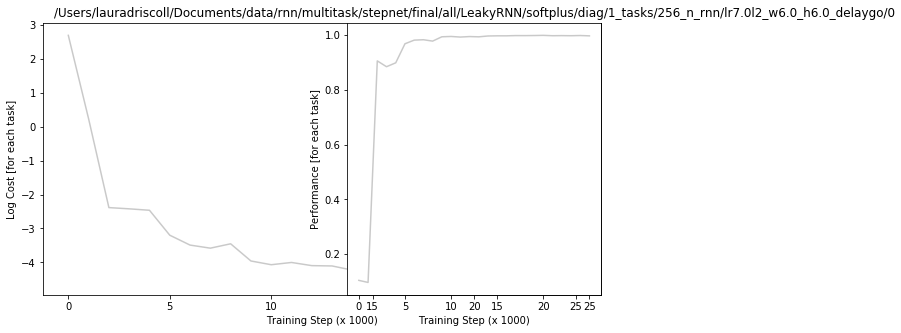

In [8]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

fig = plt.figure(figsize=(10, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

In [9]:
def plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 3, cat = False,labels=False):
    
    color_set = ['dimgray','gainsboro','dimgray','gainsboro']
    grad_cmap = plt.get_cmap('hsv')
    
    _,x1 = gen_X_from_model_dir(m,trial1)
    _,x2 = gen_X_from_model_dir(m,trial2)
    x12 = np.concatenate((x1,x2),axis = 1)
    
    n_trials_show = 20
    trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
    
#     ylim = np.max(ax.get_ylim())
#     xlim = np.max(ax.get_xlim())
    
    n_trials = len(trial1.stim_locs)
    stim_locs = np.concatenate((np.min(trial1.stim_locs,axis = 1),np.min(trial2.stim_locs,axis = 1)))
    task_binary = np.concatenate((np.ones(n_trials),np.zeros(n_trials)))
    response_binary = [((task_binary[x]==0) & (stim_locs[x]>np.pi)) or ((task_binary[x]==1) & (stim_locs[x]<np.pi))
                       for x in range(len(stim_locs))]
    
    for ti in range(len(trial_set)):
        
        trial_num = trial_set[ti]
        stim_color = grad_cmap(stim_locs[trial_num]/(2*np.pi))
        task_color = color_set[ti<int(len(trial_set)/2)]
        response_color = color_set[2+response_binary[trial_num]]
        
        if 'y' in which_axes:
            
            if cat==True:
                ax.plot(ti,-ms*.25,'s',color = response_color,markersize = ms)
            ax.plot(ti,-ms*.5,'s',color = stim_color,markersize = ms)
            ax.plot(ti,-ms*.75,'s',color = task_color,markersize = ms)
            
        if 'x' in which_axes:
            
            if cat==True:
                ax.plot(-ms*.25,ti,'s',color = response_color,markersize = ms)
            ax.plot(-ms*.5,ti,'s',color = stim_color,markersize = ms)
            ax.plot(-ms*.75,ti,'s',color = task_color,markersize = ms)
            
    if labels == True:

        if cat==True:
            plt.text(len(trial_set),-ms*.15,'respond to <$\pi$')
        plt.text(len(trial_set),-ms*.4,'stimulus angle')
        plt.text(len(trial_set),-ms*.65,'task')

In [10]:
def interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',
    tol_q = 1e-6,interp = True, cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],
    q_thresh = .001,n_skip_interps=2, rule_axs = 0,ax_labels = [], lil_axes =True, 
    plot_unstable = True,plot_zero_plane = True,color_stim = True,fig_size = 4, fontsize = 20, 
    figpath = [], ruleset = [],alpha_fp = .7,title_y = .9, n_interp = 20,n_trials = 8, 
    stability_thresh = 1,view_ang = [],z_label = []):
    
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    ax = fig.add_axes([0,0,1,1], projection='3d');
    plt.rcParams.update({'font.size': fontsize})
    al = .5

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)
    if epoch_name1==epoch_name2:
        epoch_name = epoch_name1
    
    trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
    trial2 = same_mov_inds(trial1, trial2) 
    trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

    for ri in range(2):

        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        
        if n_trials==0:
            trial_set = []
        else:
            trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/n_trials))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
        
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis=1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_grad(np.min(trial1.stim_locs[t_set[0],[0,2]])/max(np.min(trial1.stim_locs[:,[0,2]],axis=1)))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_grad(trial1.y_loc[-1,t_set[0]]/max(trial1.y_loc[-1,:]))

        if len(trial_set)>0:
            plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,c_set[trial_set],
               linewidth = 7,linestyle = '-', alpha = .3, markersize = 150, edgecolors = cmap_discrete[ri])
            plot_N3D(ax,x_epoch[[s,],:,:],D_use.T,c_set[trial_set],
               linewidth = 7,linestyle = '-', alpha = 1, markersize = 150, edgecolors = cmap_discrete[ri])

    if interp:
        for step_i in range(n_interp-1,0,-n_skip_interps):#[9, 10, 8, 11, 7, 12, 6, 13, 5, 14, 4, 15, 3, 16, 2, 17, 1, 18, 19, 0]:#
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                
                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                
                # stability_metric = alpha_max - np.max(eig_decomps[fp_ind]['evals'].real)
                # stability_metric = np.max((stability_metric,0))
                # stability_metric = np.min((stability_metric,1))
                stability_metric = alpha_fp
                facecolors_3d = c
                facecolors_2d = c
                edgecolors = c#'w'
                al = stability_metric
                
                if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                    if plot_unstable:
                        facecolors_3d = 'w'
                        ax.scatter(fp[0],fp[1],fp[2],s = 100,marker = 'o',edgecolors = edgecolors,
                           facecolors = facecolors_3d,alpha = al)
                else:   
                    s = 100
                    ax.scatter(fp[0],fp[1],fp[2],s = s,marker = 'o',edgecolors = edgecolors,
                           facecolors = facecolors_3d,alpha = al)
    
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1-.1*abs(x1),x2+.1*abs(x2)])
    ax.set_ylim([y1-.1*abs(y1),y2+.1*abs(y2)])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()


    if ax_labels=='pca_h':
        ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1', labelpad=-5)
        ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2', labelpad=-5)
        ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC3', labelpad=-5)
        save_axes = ax_labels

    if ax_labels=='pca_fp':
        ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1', labelpad=-5)
        ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2', labelpad=-5)
        ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3', labelpad=-5)
        save_axes = ax_labels

    elif len(ax_labels)==3:
        ax.set_xlabel(ax_labels[0], labelpad=0)
        ax.set_ylabel(ax_labels[1], labelpad=0)
        ax.set_zlabel(ax_labels[2],labelpad=0)
        save_axes = 'custom'

    if plot_zero_plane:
        zlabel = 'out_null'
        save_axes = zlabel
        xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
        z = xx*0
        ax.plot_surface(xx, yy, z, alpha=0.1)
        ax.set_zlabel(r"$\bf{Output}$"+r'$\cos{\theta}$',labelpad=-10)
        # ax.text(x1, y1, 0, 'Output Null', (1,0,0))
        ax.set_zlim([-1.1,1.1])
        ax.set_zticks([-1,1])

    if len(z_label)>0:
        ax.set_zlabel(z_label,labelpad=0)
        save_axes = z_label

        
    ax.set_zticks([])
    ax.set_xticks([])
    ax.set_yticks([])
        
    if rule_str[0]==rule_str[1]:
        tit = 'Single Task : '+rule_name1+'\n '+r"$\bf{"+epoch_name1+"}$"+' vs. '+r"$\bf{"+epoch_name2+"}$"+' dynamics' 
        tit_name = ruleset+'_'+rule_name1+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_3d'
    else:       
        tit = r"$\bf{"+rule_name1+"}$"+' vs. '+r"$\bf{"+rule_name2+"}$"+ '\n '+epoch_name+' dynamics'
        tit_name = ruleset+'_'+rule_name1+'_v_'+rule_name2+'_'+epoch_name+'_dynamics_3d'   
    plt.title(tit,y = title_y,fontsize  = fontsize)

    if len(view_ang)>0:
        ax.view_init(elev=view_ang[0], azim=view_ang[1])

    ax.dist = 12

    
    fig_fldr = os.path.join(figpath,'interp_fps',ruleset,rule_name_ax+'_'+save_axes)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
    plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restorin

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


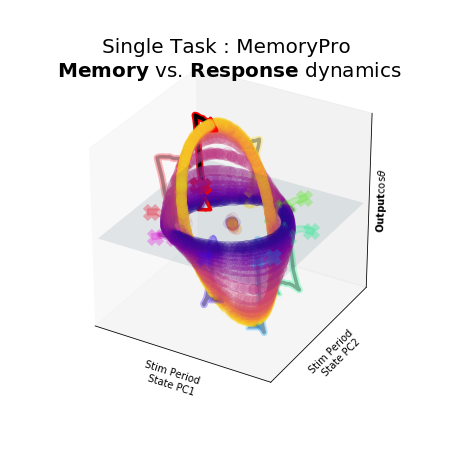

In [11]:
from tools_lnd import same_mov_inds, get_interp_filename, gen_trials_from_model_dir #make_D_use, interp3d

rule_set = [2,2]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
trial_num = [0,0]
t_set = [0,0]

#make the axes stim related
epoch_set = ['stim1','stim1']

rule_axs = 0
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = D_use[:,0]
D_use[:,1] = -D_use[:,1]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [epoch_name_ax+' Period \n State PC1',
             epoch_name_ax+' Period \n State PC2',
             epoch_name_ax+' Period \n State PC3']

epoch_set = ['delay1','go1']
script_name = 'interp_tasks_small_init_mov'
interp = True

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = 6,figpath = figpath,
         ruleset = '2task_interp',alpha_fp = .1, stability_thresh = 2, ax_labels = ax_labels)

In [34]:
# from tools_lnd import get_interp_filename, bifurc, same_mov_inds, load_fps_from_interp, plot_FPs

# fig_size = 7
# D_use = np.zeros((256,3))

# q_thresh = 1e-6
# tol_q = 1e-6
# epoch_set = ['delay1','go1']
# script_name = 'interp_tasks_small_init_mov'

# rule_set = [2,2]
# t_set = [0,0]

# rule_axs = 0
# rule = rules_dict['all'][rule_set[rule_axs]]
# rule_str = [rule, rule]
# trial = gen_trials_from_model_dir(m,rule,noise_on = False)

# filename_interp = get_interp_filename(trial,trial,epoch_set,t_set)
# fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
#                       filename_interp+'_step_'+str(0)+'.npz')

# fp_struct = np.load(fp_dir)
# sorted_fps = fp_struct['xstar']

# pca = PCA(n_components = 3)
# fp_pca = pca.fit_transform(sorted_fps)
# D_use = pca.components_.T
# D_use[:,0] = -D_use[:,0]
# w_in, b_in, w_out, b_out = get_model_params(m)
# D_use[:,2] = w_out[:,2]

# epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
# ax_labels = [r"Fixation Input $\alpha$",
#                     r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' FxdPt PC1',
#                     r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' FxdPt PC2']

# # bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
# #          q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
# #          n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
# #          figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
# #                        lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, q_thresh = q_thresh,
#                  stability_thresh = 1.05, color_stim = False, figpath = figpath, ruleset = ruleset,
#                 ax_labels = [ax_labels[1],ax_labels[2]])

# # D_use[:,0] = -D_use[:,0]
# # bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,
# #            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
# #            title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,
# #            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
# #            bifurc = False, plot_zero_plane = True)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restorin

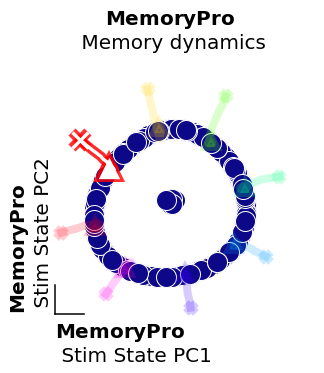

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restor

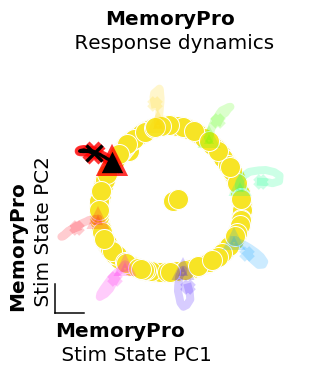

In [33]:
from tools_lnd import make_D_use, interp3d, plot_bifurc_ends, bifurc

fig_size = 5
D_use = np.zeros((256,3))

q_thresh = 1e-6
tol_q = 1e-6
epoch_set = ['delay1','go1']
script_name = 'interp_tasks_small_init_mov'

rule_set = [2,2]
t_set = [0,0]

rule_axs = 0
rule = rules_dict['all'][rule_set[rule_axs]]
rule_str = [rule, rule]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)

rule_axs = 0
epoch = 'stim1'
rule = rules_dict['all'][rule_set[rule_axs]]
ti = t_set[rule_axs]
axs = 'pca_h'
D_use = make_D_use(m,rule,epoch,ti,axs)
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = D_use[:,0]
D_use[:,1] = -D_use[:,1]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
ax_labels = [r"Fixation Input $\alpha$",
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2']

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
                       lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, q_thresh = q_thresh,
                 stability_thresh = 1.05, color_stim = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])


In [35]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True, two_period = False,
                    periods = ['Context','Stimulus']):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0),y_origin-y_diff*np.sin(np.pi/2),'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 3)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = 'dimgray',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = 'dimgray',alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = 'dimgray',alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = 'gainsboro',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = 'gainsboro',alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = 'gainsboro',alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
                
    if two_period:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = 'dimgray',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = 'dimgray',alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,periods[0],fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = 'dimgray',alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = 'gainsboro',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = 'gainsboro',alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = 'gainsboro',alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,periods[1],fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


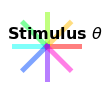

In [38]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False)

figname = 'stim_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'stim_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

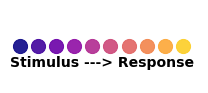

In [40]:
def interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    cmap = plt.get_cmap('plasma')
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap(step_i/n_interp)
        ax.scatter(step_i-21,0,s = 200,marker = 'o',edgecolors = c,facecolors = c,alpha = al)
    plt.text(-n_interp-2,-.06,'Stimulus ---> Response',fontsize = 14,fontweight ='bold')
#     plt.text(-2*n_interp-4,-.06,'Period Input Interpolation \n    Fixed Points:',fontsize = 14,fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_xlim([y1-3,y2])
    
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(2.6,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)

figname = 'interp_stimulus_response_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'interp_stimulus_response_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

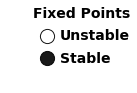

In [41]:
def fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    ax.scatter(0,1,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'w',alpha = al)
    ax.scatter(0,0,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'k',alpha = al)
    plt.text(0.04,1,'Unstable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
    plt.text(0.04,0,'Stable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
    plt.text(-0.04,2,'Fixed Points',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_ylim([y1-1,y2+1])
    
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)


figname = 'fp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'fp.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()